In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Needed Libraries

In [2]:
from tqdm import tqdm
from torchvision import datasets, transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import random
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from imblearn.over_sampling import RandomOverSampler
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


## define helper functions

In [3]:
def plot_class_distribution(class_counts, class_names, title):
    """
    Plot the distribution of classes.

    Args:
    class_counts (list): List of counts for each class.
    class_names (list): List of class names.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [4]:
def apply_oversampling(train_data):
    """
    Apply oversampling to balance the dataset.

    Args:
    train_data (torch.utils.data.Dataset): The training dataset.

    Returns:
    torch.utils.data.Subset: A balanced subset of the original training dataset after oversampling.
    """
    # Flatten the dataset to apply oversampling
    targets = [target for _, target in train_data]
    ros = RandomOverSampler(random_state=42)
    idx_resampled, _ = ros.fit_resample(np.arange(len(targets)).reshape(-1, 1), targets)
    idx_resampled = idx_resampled.flatten()
    
    # Use the resampled indexes to create a balanced dataset
    balanced_train_data = Subset(train_data, idx_resampled)
    return balanced_train_data


In [5]:
def load_and_balance_data(path, batch_size=10):
    """
    Load and balance the dataset.

    Args:
    path (str): The path to the dataset.
    batch_size (int, optional): Batch size for DataLoader (default is 10).

    Returns:
    tuple: A tuple containing train_loader, val_loader, and test_loader.
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load dataset
    dataset = datasets.ImageFolder(root=path, transform=transform)

    # Visualize class distribution before balancing
    class_counts_before = np.bincount([label for _, label in dataset])
    class_names = dataset.classes
    plot_class_distribution(class_counts_before, class_names, 'Class Distribution Before Balancing')

    # Apply oversampling
    balanced_dataset = apply_oversampling(dataset)

    # Visualize class distribution after balancing
    class_counts_after = np.bincount([label for _, label in balanced_dataset])
    plot_class_distribution(class_counts_after, class_names, 'Class Distribution After Balancing')

    # Split the dataset
    train_data, test_data = train_test_split(balanced_dataset, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    # Create DataLoader instances
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [6]:
def plot_losses(train_losses, val_losses, num_epochs):
    """
    Plot the training and validation losses.

    Args:
    train_losses (list): List of training losses.
    val_losses (list): List of validation losses.
    num_epochs (int): Number of epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [7]:
def plot_confusion_matrix(test_targets, test_preds, class_names):
    """
    Plot the confusion matrix.

    Args:
    test_targets (list): True labels of the test set.
    test_preds (list): Predicted labels of the test set.
    class_names (list): Names of the classes.
    """
    conf_matrix = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def train_model_and_evaluate(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):
    """
    Train the model, evaluate on validation set, and test on test set.

    Args:
    train_loader (torch.utils.data.DataLoader): DataLoader for training set.
    val_loader (torch.utils.data.DataLoader): DataLoader for validation set.
    test_loader (torch.utils.data.DataLoader): DataLoader for test set.
    model (torch.nn.Module): The neural network model.
    criterion: Loss function.
    optimizer: Optimization algorithm.
    num_epochs (int): Number of epochs.

    Returns:
    tuple: A tuple containing train_losses, val_losses, test_targets, and test_preds.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        # Calculate training loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation loop
        model.eval()  
        val_preds=[]
        val_targets=[]
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
        # Calculate validation loss
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)

        val_accuracy = accuracy_score(val_targets, val_preds)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Testing loop
    model.eval()  
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    # Calculate testing accuracy
    test_accuracy = accuracy_score(test_targets, test_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    return train_losses, val_losses, test_targets, test_preds

## load data and make it balance

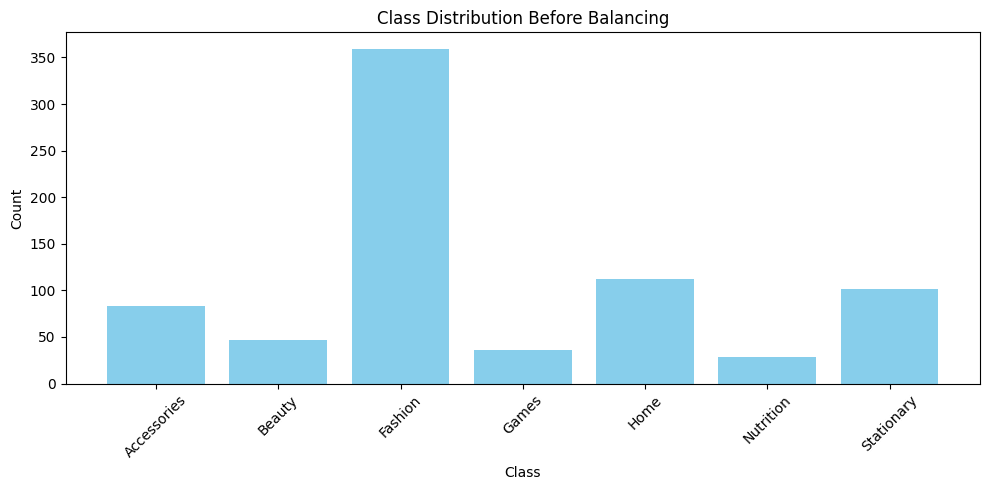

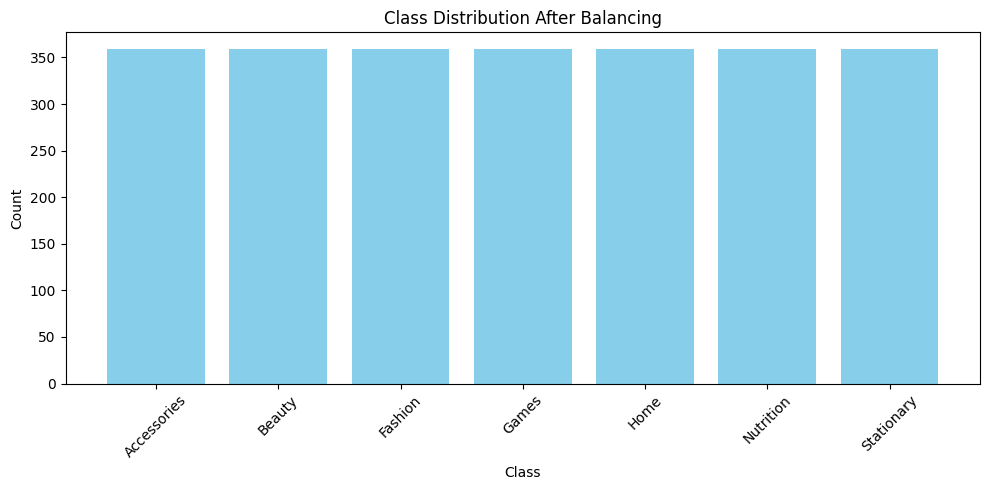

In [9]:
train_loader, val_loader, test_loader = load_and_balance_data('/kaggle/input/product-images/slash data', batch_size=10)


## Fetch a batch from train_loader

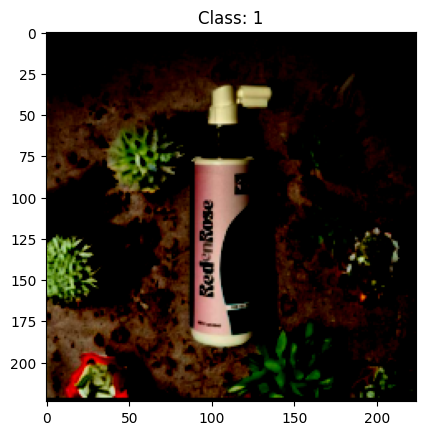

In [10]:

images, labels = next(iter(train_loader))

# Plot the first image in the batch
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.title(f'Class: {labels[0]}')
plt.show()

## define my frist model class using rasnet18

In [11]:
class ResNetClasses(nn.Module):
    """
    ResNet model for classification tasks.

    Args:
    num_classes (int): Number of classes in the classification task. Default is 7.

    Attributes:
    resnet: ResNet backbone model.
    """

    def __init__(self, num_classes=7):
        """
        Initializes the ResNetClasses model.

        Args:
        num_classes (int): Number of classes in the classification task. Default is 7.
        """
        super(ResNetClasses, self).__init__()
        self.resnet = resnet18()
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        """
        Forward pass of the ResNetClasses model.

        Args:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        return self.resnet(x)

## Training and Evaluation of ResNetClass Model

In [12]:
model = ResNetClasses()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model)
model = model.to(device)
num_epochs=10
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, test_targets, test_preds = train_model_and_evaluate(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs)


Epoch 1/10, Loss: 1.6746, Validation Loss: 1.4364, Validation Accuracy: 0.4527
Epoch 2/10, Loss: 1.2565, Validation Loss: 1.2224, Validation Accuracy: 0.5597
Epoch 3/10, Loss: 0.9850, Validation Loss: 0.9567, Validation Accuracy: 0.6692
Epoch 4/10, Loss: 0.7114, Validation Loss: 0.8016, Validation Accuracy: 0.7363
Epoch 5/10, Loss: 0.5469, Validation Loss: 0.6048, Validation Accuracy: 0.7736
Epoch 6/10, Loss: 0.4360, Validation Loss: 0.5334, Validation Accuracy: 0.8358
Epoch 7/10, Loss: 0.3332, Validation Loss: 0.3270, Validation Accuracy: 0.9154
Epoch 8/10, Loss: 0.2756, Validation Loss: 0.3186, Validation Accuracy: 0.8980
Epoch 9/10, Loss: 0.1681, Validation Loss: 0.2741, Validation Accuracy: 0.9303
Epoch 10/10, Loss: 0.1580, Validation Loss: 0.2974, Validation Accuracy: 0.9154
Test Accuracy: 0.9384


## Plotting Training and Validation Losses

###  ploting the training and validation losses over the number of epochs to visually inspect the model's learning progress and check for signs of overfitting. The close tracking of validation loss with training loss suggests that there is no significant overfitting observed.


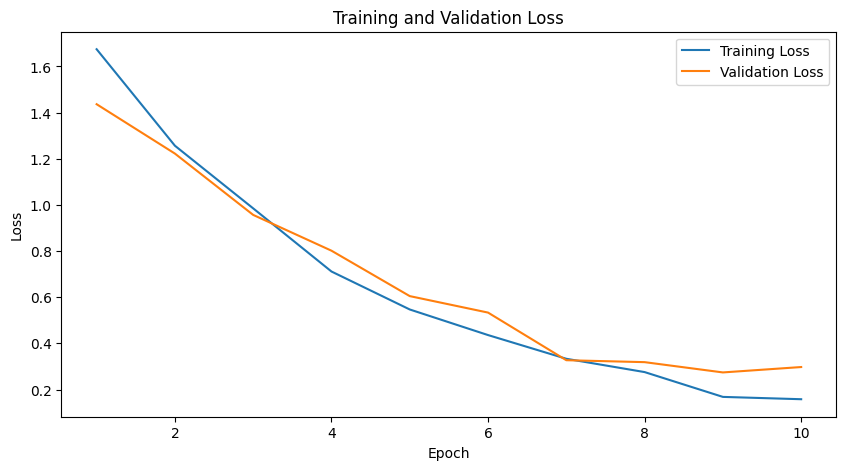

In [13]:
plot_losses(train_losses, val_losses, num_epochs)

## Confusion Matrix

### visualizing the confusion matrix to understand how well the model performs on each class. By examining the diagonal elements, which indicate correctly classified instances for each class, we gain insights into the model's performance across different classes.


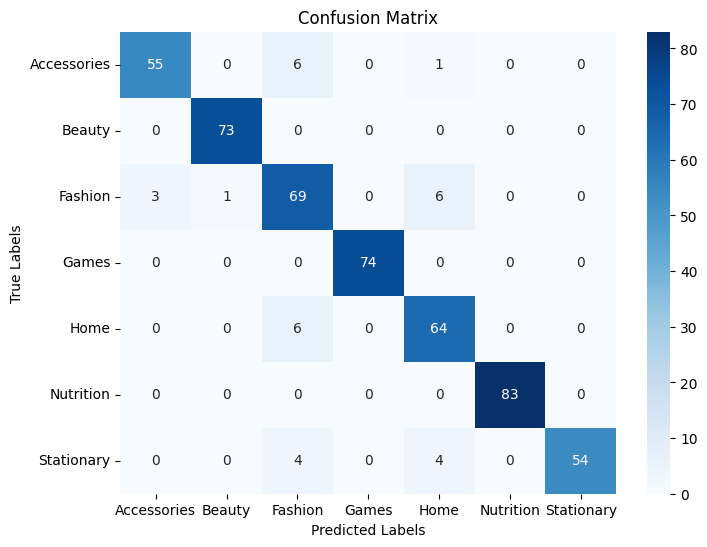

In [14]:
class_names = ['Accessories','Beauty','Fashion', 'Games', 'Home', 'Nutrition','Stationary']  
plot_confusion_matrix(test_targets, test_preds, class_names)

## define Convolutional Neural Network model for Image Classification

In [15]:
class ModelCNN(nn.Module):
    """
    Convolutional Neural Network (CNN) model for image classification tasks.

    Args:
    num_classes (int): Number of classes in the classification task.

    Attributes:
    conv1: Convolutional layer 1.
    conv2: Convolutional layer 2.
    conv3: Convolutional layer 3.
    fc1: Fully connected layer 1.
    fc2: Fully connected layer 2.
    relu: ReLU activation function.
    maxpool: Max pooling layer.
    dropout: Dropout layer for regularization.
    """

    def __init__(self, num_classes):
        """
        Initializes the ModelCNN.

        Args:
        num_classes (int): Number of classes in the classification task.
        """
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        """
        Forward pass of the ModelCNN.

        Args:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor.
        """
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(-1, 128 * 28 * 28)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Training and Evaluation of ModelCNN Model

In [16]:
num_classes = 7  
model = ModelCNN(num_classes)
model = nn.DataParallel(model)
model = model.to(device)
num_epochs=10
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, test_targets, test_preds = train_model_and_evaluate(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.4466, Validation Loss: 0.7136, Validation Accuracy: 0.7488
Epoch 2/10, Loss: 0.5307, Validation Loss: 0.4318, Validation Accuracy: 0.8731
Epoch 3/10, Loss: 0.1625, Validation Loss: 0.2980, Validation Accuracy: 0.9030
Epoch 4/10, Loss: 0.1098, Validation Loss: 0.2598, Validation Accuracy: 0.9279
Epoch 5/10, Loss: 0.0539, Validation Loss: 0.3333, Validation Accuracy: 0.9254
Epoch 6/10, Loss: 0.0718, Validation Loss: 0.2544, Validation Accuracy: 0.9353
Epoch 7/10, Loss: 0.0456, Validation Loss: 0.2977, Validation Accuracy: 0.9353
Epoch 8/10, Loss: 0.0403, Validation Loss: 0.2559, Validation Accuracy: 0.9403
Epoch 9/10, Loss: 0.0135, Validation Loss: 0.2914, Validation Accuracy: 0.9453
Epoch 10/10, Loss: 0.0015, Validation Loss: 0.2986, Validation Accuracy: 0.9478
Test Accuracy: 0.9503


## Plotting Training and Validation Losses

### The close tracking of validation loss with training loss suggests that there is no significant overfitting observed.

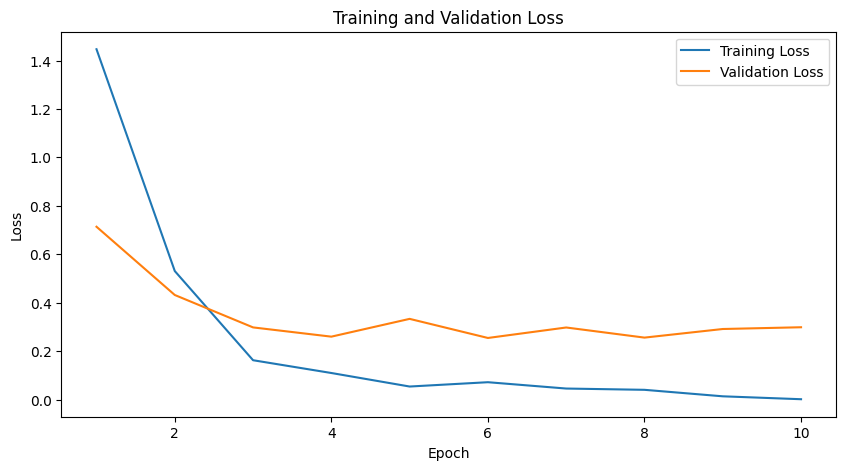

In [17]:
plot_losses(train_losses, val_losses, num_epochs)

## plotting Confusion Matrix 
### which appears the second model perform well and the result is so near from the frist model 

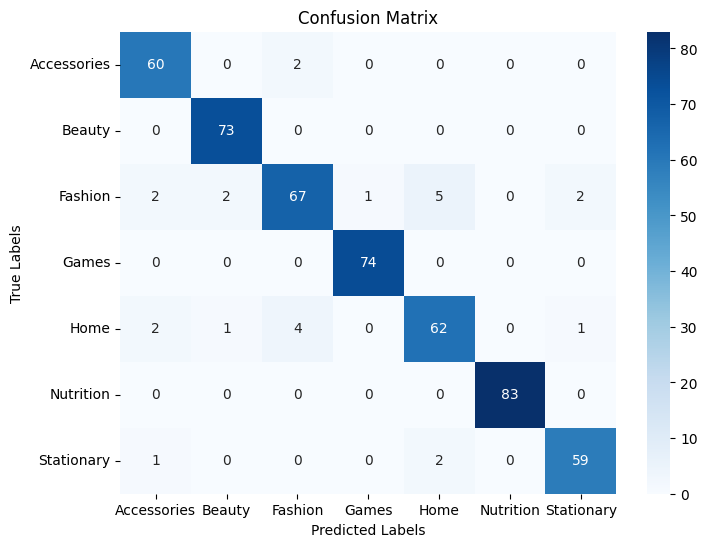

In [18]:

class_names = ['Accessories','Beauty','Fashion', 'Games', 'Home', 'Nutrition','Stationary']  
plot_confusion_matrix(test_targets, test_preds, class_names)